In [ ]:
#IMPORTS
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from keras.utils import *
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

Se carga el dataset

In [ ]:
#Cargar dataset

datos= pd.read_csv('p1_dataset_elpino_raw.csv',sep=";")
df = pd.DataFrame(datos)

Renombre de variables

In [ ]:

#RENOMBRAR DIAGNOSTICOS
df = df.rename(columns={'Diag 01 Principal (cod+des)': 'Diag_principal'})
column_names = df.columns[1:35].tolist()
for i, col_name in enumerate(column_names):
    new_name = f"Diag{i+2}"
    df = df.rename(columns={col_name: new_name})


#RENOMBRAR PROCEDIMIENTOS
df = df.rename(columns={'Proced 01 Principal (cod+des)': 'Proced_principal'})
column_names = df.columns[36:65].tolist()
for i, col_name in enumerate(column_names):
    new_name = f"Proced{i+2}"
    df = df.rename(columns={col_name: new_name})

df = df.rename(columns={'Edad en años': 'Edad'})
df = df.rename(columns={'Sexo (Desc)': 'Sexo'})
print(df.columns)



Index(['Diag_principal', 'Diag2', 'Diag3', 'Diag4', 'Diag5', 'Diag6', 'Diag7',
       'Diag8', 'Diag9', 'Diag10', 'Diag11', 'Diag12', 'Diag13', 'Diag14',
       'Diag15', 'Diag16', 'Diag17', 'Diag18', 'Diag19', 'Diag20', 'Diag21',
       'Diag22', 'Diag23', 'Diag24', 'Diag25', 'Diag26', 'Diag27', 'Diag28',
       'Diag29', 'Diag30', 'Diag31', 'Diag32', 'Diag33', 'Diag34', 'Diag35',
       'Proced_principal', 'Proced2', 'Proced3', 'Proced4', 'Proced5',
       'Proced6', 'Proced7', 'Proced8', 'Proced9', 'Proced10', 'Proced11',
       'Proced12', 'Proced13', 'Proced14', 'Proced15', 'Proced16', 'Proced17',
       'Proced18', 'Proced19', 'Proced20', 'Proced21', 'Proced22', 'Proced23',
       'Proced24', 'Proced25', 'Proced26', 'Proced27', 'Proced28', 'Proced29',
       'Proced30', 'Edad', 'Sexo', 'GRD'],
      dtype='object')


Limpiando las variables

In [ ]:
#SACAR EL TEXTO DE LAS VARIABLES

#Definir una función para extraer los números de una cadena
df = df.astype(str)

# Funcion que extrae primera parte de un string
def extraer_primera_parte(cadena):
    return cadena.split()[0]
    
#EXTRAER NUMEROS DE PROCEDIMIENTOS
df['Proced_principal'] = df['Proced_principal'].apply(extraer_primera_parte)

indices = list(df.columns)
columnas=indices[36:65]
for col in columnas:
    df[col] = df[col].apply(extraer_primera_parte)


# Funcion que extrae primera parte de un string
def extraer_primera_parte(cadena):
    return cadena.split()[0]
    
#EXTRAER NUMEROS DE PROCEDIMIENTOS
columnass=indices[:35]
df['Diag_principal'] = df['Diag_principal'].apply(extraer_primera_parte)
for col in columnass:
    df[col] = df[col].apply(extraer_primera_parte)

#EXTRAER NUMEROS DEL GRD
df['GRD'] = df['GRD'].apply(extraer_primera_parte)

#df.head()

#Se pasa el sexo a numero binario
X = df.iloc[: ,0:67].values
sexo_le = LabelEncoder()
df['Sexo'] = sexo_le.fit_transform(X[:,66])

#SE SACA EL ULTIMO DIGITO DEL GRD
df['GRD'] = df['GRD'].astype(str).str[:-1]


#PASAR A FLOAT LOS PROCEDIMIENTOS Y REEMPLAZAR LOS GUIONES POR 0. TAMBIEN LA EDAD COMO ENTERO
for col in columnas:
  df[col] = df[col].replace('-', '0')
  df[col] = df[col].astype(np.float32)
df['Edad'] = df['Edad'].astype(np.int32)

#SEXO Y GRD A CATEGORICAL
df['GRD'] = pd.Categorical(df['GRD'])
df['Sexo'] = pd.Categorical(df['Sexo'])

cols= df.columns[35:65]
for col in cols:
  df[col] = df[col].astype(np.float32)
  #df[col] = round(df[col],2)


#df.info()


Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Crear una instancia de LabelEncoder

le = LabelEncoder()
col = df.columns[0:35]

for c in col:
  df[c] = le.fit_transform(df[c])

df

,Diag_principal,Diag2,Diag3,Diag4,Diag5,Diag6,Diag7,Diag8,Diag9,Diag10,...,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,Edad,Sexo,GRD
0,24,44,380,654,38,471,393,26,6,244,...,99.839996,88.720001,90.419998,90.519997,91.389999,91.330002,87.029999,40,0,18410
1,1450,527,1032,905,812,847,706,297,265,246,...,91.620003,90.430000,91.389999,90.519997,91.320000,96.589996,90.989998,53,0,04101
2,623,1200,1068,463,997,337,660,23,31,9,...,99.839996,91.730003,90.529999,99.260002,89.389999,89.660004,89.650002,65,0,04101
3,670,689,724,120,172,152,322,414,256,418,...,57.939999,0.130000,0.170000,99.040001,99.180000,99.209999,99.230003,61,0,04102
4,1427,1611,1121,982,942,370,298,578,499,354,...,90.519997,91.389999,91.320000,93.900002,99.150002,96.589996,45.130001,30,0,04102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14556,196,571,218,221,1117,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26,1,10410
14557,1239,1448,1064,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10,0,01424
14558,704,394,161,378,443,478,201,750,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58,0,06418
14559,222,394,1481,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47,0,10412


Análisis descriptivo

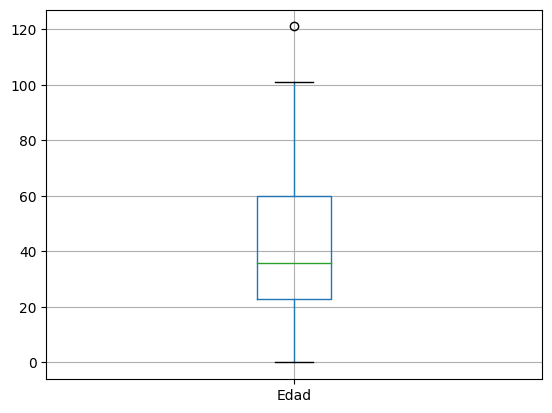

count    14561.000000
mean        39.426550
std         24.681545
min          0.000000
25%         23.000000
50%         36.000000
75%         60.000000
max        121.000000
Name: Edad, dtype: float64

In [ ]:
#EDAD

df.boxplot(column=['Edad'])
plt.show()
df['Edad'].describe()

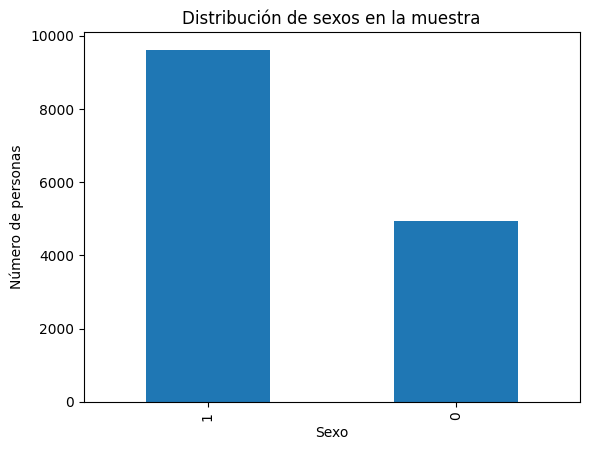

count     14561
unique        2
top           1
freq       9617
Name: Sexo, dtype: int64

In [ ]:
#SEXO
sexo_counts = df['Sexo'].value_counts()
sexo_counts.plot(kind='bar')
plt.xlabel('Sexo')
plt.ylabel('Número de personas')
plt.title('Distribución de sexos en la muestra')

# mostrar el gráfico
plt.show()


df['Sexo'].describe()


In [ ]:
#GRD
df['GRD'].describe()

count     14561
unique      210
top       14610
freq       1220
Name: GRD, dtype: object

In [ ]:
#PROCED PRINCIPAL
df['Proced_principal'].describe()

count    14561.000000
mean        77.308815
std         16.450047
min          0.140000
25%         73.589996
50%         87.029999
75%         88.430000
max         99.980003
Name: Proced_principal, dtype: float64

In [ ]:
#DIAG PRINCIPAL
df['Diag_principal'].describe()


count    14561.000000
mean       761.643500
std        371.264673
min          0.000000
25%        497.000000
50%        788.000000
75%       1007.000000
max       1490.000000
Name: Diag_principal, dtype: float64

Correlación entre variables

In [ ]:
#Eliminamos las columnas con baja correlación

df1 = df.iloc[:, list(range(15)) + list(range(35, 50)) + list(range(65, 68))]

df1.columns

Index(['Diag_principal', 'Diag2', 'Diag3', 'Diag4', 'Diag5', 'Diag6', 'Diag7',
       'Diag8', 'Diag9', 'Diag10', 'Diag11', 'Diag12', 'Diag13', 'Diag14',
       'Diag15', 'Proced_principal', 'Proced2', 'Proced3', 'Proced4',
       'Proced5', 'Proced6', 'Proced7', 'Proced8', 'Proced9', 'Proced10',
       'Proced11', 'Proced12', 'Proced13', 'Proced14', 'Proced15', 'Edad',
       'Sexo', 'GRD'],
      dtype='object')

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14561 entries, 0 to 14560
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Diag_principal    14561 non-null  int64   
 1   Diag2             14561 non-null  int64   
 2   Diag3             14561 non-null  int64   
 3   Diag4             14561 non-null  int64   
 4   Diag5             14561 non-null  int64   
 5   Diag6             14561 non-null  int64   
 6   Diag7             14561 non-null  int64   
 7   Diag8             14561 non-null  int64   
 8   Diag9             14561 non-null  int64   
 9   Diag10            14561 non-null  int64   
 10  Diag11            14561 non-null  int64   
 11  Diag12            14561 non-null  int64   
 12  Diag13            14561 non-null  int64   
 13  Diag14            14561 non-null  int64   
 14  Diag15            14561 non-null  int64   
 15  Proced_principal  14561 non-null  float32 
 16  Proced2           1456

Partición de Datos

In [ ]:
X = df1.iloc[:, :-1]
y = df1.iloc[:, -1]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=42)

# Escalar características
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xval = scaler.transform(Xval)
Xtest = scaler.transform(Xtest)

Balanceo de datos

In [ ]:
#Verificamos el desbalanceo de datos en la columna GRD
print("Desbalanceo de datos en la columna GRD\n")
print(df1.shape)
print(pd.value_counts(df1['GRD'], sort = True))

print("\nDesbalanceo de datos en la columna Diag_principal\n")
print(df1.shape)
print(pd.value_counts(df1['Diag_principal'], sort = True))

print(pd.value_counts(df1['Proced15'], sort = True))


Desbalanceo de datos en la columna GRD

(14561, 33)
14610    1220
14612     927
14613     741
07114     501
13416     458
         ... 
08420       1
10110       1
10120       1
12111       1
01120       1
Name: GRD, Length: 210, dtype: int64

Desbalanceo de datos en la columna Diag_principal

(14561, 33)
1007    779
1028    471
1450    327
942     304
202     215
       ... 
176       1
1488      1
348       1
469       1
1087      1
Name: Diag_principal, Length: 1491, dtype: int64
0.000000     10111
89.699997      348
93.820000      216
93.180000      189
93.010002      174
             ...  
46.709999        1
23.090000        1
88.430000        1
93.540001        1
90.010002        1
Name: Proced15, Length: 155, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.datasets import make_classification

# crear una instancia de RandomOverSampler
ros = RandomOverSampler(random_state=0)

# aplicar oversampling a los datos
Xtrain_B, Ytrain_B = ros.fit_resample(Xtrain, Ytrain)
print(f"Tamaño de los datos antes de oversampling: {Xtrain.shape}")
print(f"Tamaño de los datos después de oversampling: {Xtrain_B.shape}")

Tamaño de los datos antes de oversampling: (8736, 32)
Tamaño de los datos después de oversampling: (152096, 32)


In [ ]:
#Edad y sexo a Int32
# df1['Edad'] = df1['Edad'].astype(np.int64)

#Diagnosticos a Int32
c= df1.columns[0:15]
for col in c:
  df1[col] = df1[col].astype(np.int64)

#Procedimientos a Int32
cols= df1.columns[15:30]
for col in cols:
  df1[col] = df1[col].astype(np.int64)

# #Transformar el GRD a categorical
df1['GRD'] = pd.Categorical(df1['GRD'])


<ipython-input-16-8bd882038b63>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype(np.int64)
<ipython-input-16-8bd882038b63>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[col] = df1[col].astype(np.int64)
<ipython-input-16-8bd882038b63>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [ ]:
#Verificamos el tipo de variable de cada Grupo y ademas la existencia de valores nulos
print(df1['GRD'].astype)
print(df1['Diag_principal'].astype)
print(df1['Proced9'].astype)
print(df1['Edad'].astype)
print(df1.isnull().sum())


<bound method NDFrame.astype of 0        18410
1        04101
2        04101
3        04102
4        04102
         ...  
14556    10410
14557    01424
14558    06418
14559    10412
14560    04120
Name: GRD, Length: 14561, dtype: category
Categories (210, object): ['01120', '01410', '01411', '01413', ..., '21417', '22410', '22411', '22412']>
<bound method NDFrame.astype of 0          24
1        1450
2         623
3         670
4        1427
         ... 
14556     196
14557    1239
14558     704
14559     222
14560    1231
Name: Diag_principal, Length: 14561, dtype: int64>
<bound method NDFrame.astype of 0        87
1        88
2        88
3        88
4        96
         ..
14556    57
14557     0
14558     0
14559     0
14560    89
Name: Proced9, Length: 14561, dtype: int64>
<bound method NDFrame.astype of 0        40
1        53
2        65
3        61
4        30
         ..
14556    26
14557    10
14558    58
14559    47
14560    73
Name: Edad, Length: 14561, dtype: int32>
Diag_p

In [ ]:
num_classes = len(np.unique(Ytrain))
num_col = len(df1.columns)
print(num_classes)
print(num_col)


196
33


Creación del Modelo

In [ ]:
from keras.utils import np_utils
Ytrain = np_utils.to_categorical(Ytrain)
Yval = np_utils.to_categorical(Yval)
Ytest = np_utils.to_categorical(Ytest)

In [ ]:
import keras
from keras import *
from keras.layers import *

Model = Sequential()

Model.add(Dense(80, input_shape=(Xtrain.shape[1],) , activation="relu"))
Model.add(Dense(240, activation="relu"))
Model.add(Dense(120, activation="relu"))
Model.add(Dense(22413, activation = "softmax")) 

Model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# Model.summary()

In [ ]:
a=Model.fit(Xtrain, Ytrain, epochs= 100 , validation_data=(Xval,Yval), batch_size=64)

Epoch 1/100
137/137 [==============================] - 6s 22ms/step - loss: 4.6507 - accuracy: 0.1633 - val_loss: 3.3573 - val_accuracy: 0.2479
Epoch 2/100
137/137 [==============================] - 2s 17ms/step - loss: 2.9815 - accuracy: 0.3038 - val_loss: 2.8184 - val_accuracy: 0.3455
Epoch 3/100
137/137 [==============================] - 2s 18ms/step - loss: 2.5725 - accuracy: 0.3693 - val_loss: 2.5627 - val_accuracy: 0.3901
Epoch 4/100
137/137 [==============================] - 3s 19ms/step - loss: 2.3453 - accuracy: 0.4072 - val_loss: 2.4180 - val_accuracy: 0.3973
Epoch 5/100
137/137 [==============================] - 2s 17ms/step - loss: 2.1537 - accuracy: 0.4465 - val_loss: 2.2711 - val_accuracy: 0.4423
Epoch 6/100
137/137 [==============================] - 3s 19ms/step - loss: 2.0041 - accuracy: 0.4653 - val_loss: 2.1706 - val_accuracy: 0.4636
Epoch 7/100
137/137 [==============================] - 3s 19ms/step - loss: 1.8867 - accuracy: 0.4875 - val_loss: 2.1259 - val_accuracy:

In [ ]:
#Modelo 2

import keras
from keras import *
from keras.layers import *

Model2 = Sequential()

Model2.add(Dense(120, input_shape=(Xtrain.shape[1],) , activation="relu"))
Model2.add(Dense(560, activation="relu"))
Model2.add(Dense(240, activation="relu"))
Model2.add(Dense(22413, activation = "softmax")) 

Model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
a2=Model2.fit(Xtrain, Ytrain, epochs= 100 , validation_data=(Xval,Yval), batch_size=64)

Epoch 1/100
137/137 [==============================] - 5s 21ms/step - loss: 4.2761 - accuracy: 0.1900 - val_loss: 3.0562 - val_accuracy: 0.3005
Epoch 2/100
137/137 [==============================] - 2s 14ms/step - loss: 2.7208 - accuracy: 0.3488 - val_loss: 2.6515 - val_accuracy: 0.3527
Epoch 3/100
137/137 [==============================] - 2s 16ms/step - loss: 2.3592 - accuracy: 0.4085 - val_loss: 2.4071 - val_accuracy: 0.4011
Epoch 4/100
137/137 [==============================] - 2s 15ms/step - loss: 2.1055 - accuracy: 0.4443 - val_loss: 2.1817 - val_accuracy: 0.4622
Epoch 5/100
137/137 [==============================] - 2s 16ms/step - loss: 1.9247 - accuracy: 0.4752 - val_loss: 2.1176 - val_accuracy: 0.4739
Epoch 6/100
137/137 [==============================] - 2s 14ms/step - loss: 1.7882 - accuracy: 0.4966 - val_loss: 2.0859 - val_accuracy: 0.4760
Epoch 7/100
137/137 [==============================] - 2s 14ms/step - loss: 1.6678 - accuracy: 0.5198 - val_loss: 2.0588 - val_accuracy:

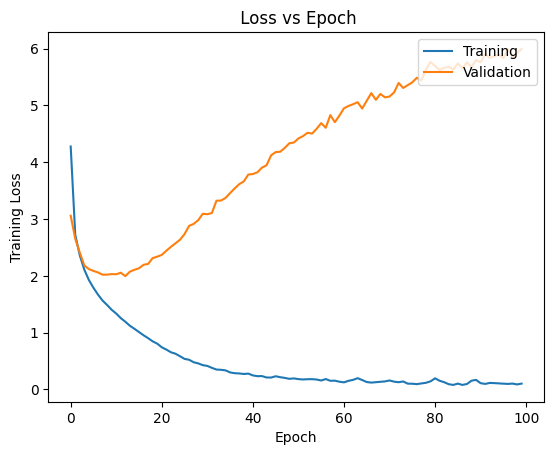

In [ ]:
plt.plot(a2.history['loss'])
plt.plot(a2.history['val_loss'])
plt.title(' Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()

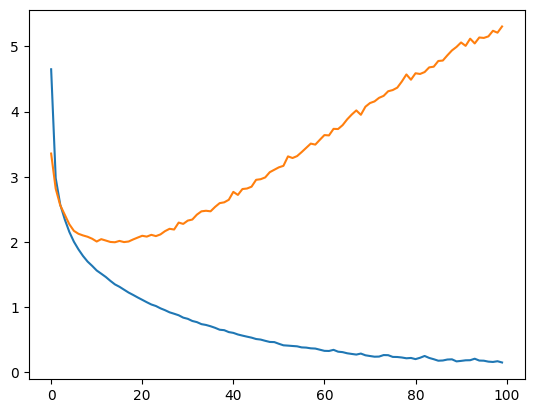

In [ ]:

plt.plot(a.history['loss'])
plt.plot(a.history['val_loss'])

In [ ]:
#Predicción Modelo 2

# hacer predicciones en el conjunto de prueba
Y_pred = Model2.predict(Xtest)

# imprimir las predicciones
print(Y_pred)

92/92 [==============================] - 0s 1ms/step
[[1.1443451e-10 1.7712606e-10 1.0272213e-10 ... 1.0891606e-10
  2.7371560e-11 7.9156971e-06]
 [4.8145313e-27 9.8686831e-27 3.2339515e-27 ... 3.9897426e-27
  1.0053121e-33 2.4985453e-28]
 [2.2222242e-22 1.3295096e-22 1.5510135e-22 ... 1.0038421e-22
  6.6821958e-35 4.6344906e-26]
 ...
 [1.5929259e-20 1.0050483e-20 5.5759336e-21 ... 7.1632734e-21
  1.4387315e-13 6.0301768e-12]
 [1.9808325e-15 7.7946042e-16 1.2015227e-15 ... 6.5585592e-16
  8.4294440e-15 1.1605177e-19]
 [1.7745816e-13 1.9394402e-13 1.2732072e-13 ... 1.3905279e-13
  8.7852007e-18 3.6256709e-11]]


In [ ]:
#Modelo 3

import keras
from keras import *
from keras.layers import *

Model3 = Sequential()

Model3.add(Dense(100, input_shape=(Xtrain.shape[1],) , activation="relu"))
Model3.add(Dense(620, activation="relu"))
Dropout(0.4)
Model3.add(Dense(80, activation="relu"))
Model3.add(Dense(22413, activation = "softmax")) 

Model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
a3=Model3.fit(Xtrain, Ytrain, epochs= 100 , validation_data=(Xval,Yval), batch_size=64)

Epoch 1/100
137/137 [==============================] - 4s 19ms/step - loss: 4.5889 - accuracy: 0.1549 - val_loss: 3.3357 - val_accuracy: 0.2675
Epoch 2/100
137/137 [==============================] - 2s 16ms/step - loss: 2.9709 - accuracy: 0.3078 - val_loss: 2.8865 - val_accuracy: 0.2912
Epoch 3/100
137/137 [==============================] - 2s 14ms/step - loss: 2.6309 - accuracy: 0.3587 - val_loss: 2.6266 - val_accuracy: 0.3733
Epoch 4/100
137/137 [==============================] - 2s 15ms/step - loss: 2.3868 - accuracy: 0.4060 - val_loss: 2.4293 - val_accuracy: 0.4172
Epoch 5/100
137/137 [==============================] - 2s 16ms/step - loss: 2.1777 - accuracy: 0.4330 - val_loss: 2.3052 - val_accuracy: 0.4310
Epoch 6/100
137/137 [==============================] - 2s 14ms/step - loss: 1.9979 - accuracy: 0.4709 - val_loss: 2.1782 - val_accuracy: 0.4578
Epoch 7/100
137/137 [==============================] - 2s 14ms/step - loss: 1.8739 - accuracy: 0.4855 - val_loss: 2.1125 - val_accuracy:

In [ ]:
#Predicción Modelo 3

# hacer predicciones en el conjunto de prueba
Y_pred = Model3.predict(Xtest)

# imprimir las predicciones
print(Y_pred)

92/92 [==============================] - 0s 1ms/step
[[1.8645659e-10 9.6611989e-11 1.3983770e-10 ... 2.0939539e-10
  9.4029489e-12 1.1848139e-08]
 [9.8021540e-31 1.1929671e-30 4.7036993e-31 ... 1.1546060e-30
  0.0000000e+00 4.6740077e-31]
 [2.1610885e-32 4.8320943e-33 8.5850739e-33 ... 4.4554610e-32
  0.0000000e+00 3.7895236e-36]
 ...
 [3.6708333e-24 1.4084201e-23 2.8186083e-24 ... 1.1120884e-23
  3.3788781e-14 3.2236154e-09]
 [2.0638085e-17 2.1649495e-17 3.9786114e-17 ... 2.3905272e-18
  1.5056346e-18 1.6236751e-14]
 [4.5211206e-13 4.0854269e-13 2.1456661e-13 ... 6.7878597e-13
  1.5367331e-12 3.9994088e-08]]


Árbol de decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

arbol = DecisionTreeClassifier()
arbol.fit(Xtrain, Ytrain)

# hacer predicciones en el conjunto de prueba
Ypred = arbol.predict(Xtest)

# calcular la precisión de las predicciones
accuracy = accuracy_score(Ytest, Ypred)
print('Precisión: {:.2f}'.format(accuracy))

Precisión: 0.81


SVM

In [ ]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Crea un objeto SVM y especifica el kernel utilizado
svm = SVC(kernel='linear')

# Entrena el modelo SVM utilizando los datos de entrenamiento
svm.fit(Xtrain, Ytrain)

In [ ]:
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Exactitud: {:.2f}'.format(accuracy))

SHAP

In [ ]:
!pip install shap

In [ ]:
import shap

explainer = shap.KernelExplainer(Model.predict, Xtrain)
# Calcula los valores shap
shap_values = explainer.shap_values(Xtest)

shap.force_plot(explainer.expected_value, shap_values[0,:], Xtest[0,:])